In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from multiprocessing import cpu_count
from itertools import islice

import pandas as pd
import numpy as np

import gensim
from gensim.models import Word2Vec

from scipy.linalg import norm
from sklearn.decomposition import PCA

from tqdm.contrib.concurrent import process_map

from matplotlib import pyplot as plt

from transform import *
from callbacks import *
from utils import *

np.random.seed(2021)

In [3]:
!mkdir -p data

In [4]:
!python3 -m wikiextractor.WikiExtractor -h >/dev/null 2>&1 || pip install --user wikiextractor

In [5]:
DS_ROOT = Path("data".rstrip("/"))
![ -f "{DS_ROOT}/enwik8.zip" ] || [ -f "{DS_ROOT}/enwik8" ] || wget -P "{DS_ROOT}" http://cs.fit.edu/~mmahoney/compression/enwik8.zip
![ -f "{DS_ROOT}/enwik8.zip" ] && unzip -o -d "{DS_ROOT}" "{DS_ROOT}/enwik8.zip" && rm "{DS_ROOT}/enwik8.zip"
!head -n 10 "{DS_ROOT}/enwik8"
![ -f "{DS_ROOT}/enwik8_clean" ] || \
 ( echo "Extracting and cleaning {DS_ROOT}/enwik8 to {DS_ROOT}/enwik8_clean..." && \
   python3 -m wikiextractor.WikiExtractor "{DS_ROOT}/enwik8" --processes 8 -q -o - \
    | sed "/^\s*\$/d" \
    | grep -v "^<doc id=" \
    | grep -v "</doc>\$" \
    > "{DS_ROOT}/enwik8_clean" && \
    echo "Succesfully extracted and cleaned {DS_ROOT}/enwik8 to {DS_ROOT}/enwik8_clean" )

<mediawiki xmlns="http://www.mediawiki.org/xml/export-0.3/" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.mediawiki.org/xml/export-0.3/ http://www.mediawiki.org/xml/export-0.3.xsd" version="0.3" xml:lang="en">
  <siteinfo>
    <sitename>Wikipedia</sitename>
    <base>http://en.wikipedia.org/wiki/Main_Page</base>
    <generator>MediaWiki 1.6alpha</generator>
    <case>first-letter</case>
      <namespaces>
      <namespace key="-2">Media</namespace>
      <namespace key="-1">Special</namespace>
      <namespace key="0" />


In [6]:
!head -n 10 "{DS_ROOT}/enwik8_clean"

AaA
AlgeriA
AmericanSamoa
AppliedEthics
AccessibleComputing
AdA
Anarchism
Anarchism originated as a term of abuse first used against early working class radicals including the Diggers of the English Revolution and the "sans-culottes" of the French Revolution. Whilst the term is still used in a pejorative way to describe "any act that used violent means to destroy the organization of society", it has also been taken up as a positive label by self-defined anarchists.
The word anarchism is derived from the Greek "" ("without archons (ruler, chief, king)"). Anarchism as a political philosophy, is the belief that "rulers" are unnecessary and should be abolished, although there are differing interpretations of what this means. Anarchism also refers to related social movements) that advocate the elimination of authoritarian institutions, particularly the state. The word "anarchy," as most anarchists use it, does not imply chaos, nihilism, or anomie, but rather a harmonious anti-authoritarian 

In [7]:
!python -m nltk.downloader punkt

/usr/lib/python3.9/runpy.py:127: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /home/chino/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
sentences = load_sentences(DS_ROOT/'enwik8_clean')

In [9]:
transform = TextTransform(pre_process=None)

In [10]:
indices = np.random.permutation(range(len(sentences)))

In [11]:
train_sentences = [sentences[i] for i in indices[:10_000]]

In [12]:
train_sentences = process_map(transform, train_sentences, max_workers=cpu_count(), chunksize=10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [13]:
lens = [len(x) for x in train_sentences]

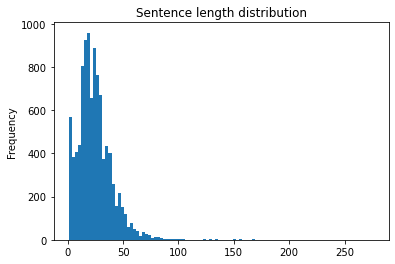

In [14]:
pd.Series(lens).plot.hist(bins=100)
plt.title("Sentence length distribution")
plt.show()

In [19]:
centroid_callback = CentroidCalculation()
hparams_callback = HyperParamLogger(alpha=lambda model: model.min_alpha_yet_reached)

w2v = Word2Vec(sentences=train_sentences,
               workers=cpu_count(),
               alpha=0.025,
               min_alpha=0.01,
               size=100,
               window=5,
               min_count=5,
               sg=1,
               negative=5,
               callbacks=[centroid_callback,
                          hparams_callback,
                          EpochLogger()],
               iter=50)

  0%|          | 0/50 [00:00<?, ?epoch/s]

In [16]:
def show_centroid_shift(centroids, epoch_split=3):
    epochs = centroids.shape[0]-1
    shift_norm_centroid_hist = rowise_distance(centroids[1:],centroids[:-1])
    shift_sim_centroid_hist = rowise_cosine_sim(centroids[1:],centroids[:-1])

    fig, axs = plt.subplots(figsize=(20, 10), ncols=2, nrows=2)

    axs[0][0].set_title(f"First {epoch_split} epochs")
    axs[0][0].set_ylabel("Distance")
    axs[0][0].plot(range(1,epoch_split+1),shift_norm_centroid_hist[:epoch_split])
    axs[0][1].set_ylabel("Distance")
    axs[0][1].set_title(f"Last {epochs-epoch_split} epochs")
    axs[0][1].plot(range(epoch_split+1,epochs+1),shift_norm_centroid_hist[epoch_split:])


    axs[1][0].set_title(f"First {epoch_split} epochs")
    axs[1][0].set_ylabel("Similarity")
    axs[1][0].plot(range(1,epoch_split+1),shift_sim_centroid_hist[:epoch_split])
    axs[1][1].set_ylabel("Similarity")
    axs[1][1].set_title(f"Last {epochs-epoch_split} epochs")
    axs[1][1].plot(range(epoch_split+1,epochs+1),shift_sim_centroid_hist[epoch_split:])

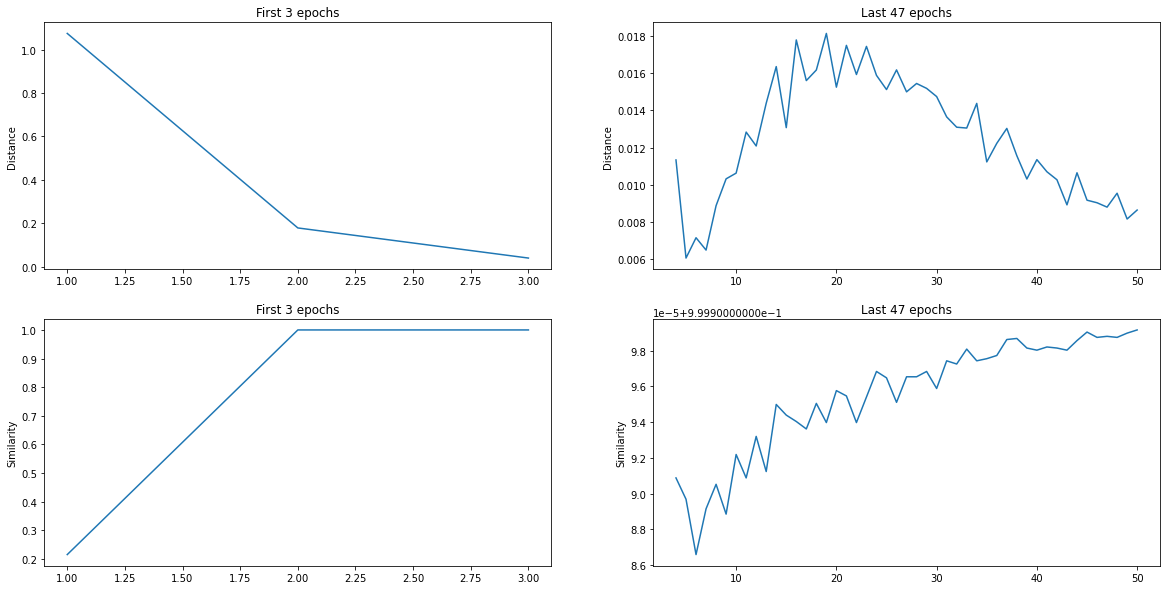

In [17]:
show_centroid_shift(centroid_callback.centroids)
plt.show()